In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [39]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import requests 
import json
from dateutil.relativedelta import relativedelta
from datetime import date

In [89]:
## Functions 

def FRSI(series, period=14):
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - (100 / (1 + rs))


# calculating Stoch RSI (gives the same values as TradingView)
# https://www.tradingview.com/wiki/Stochastic_RSI_(STOCH_RSI) 
def STRSIA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()
    return stochrsi, stochrsi_K, stochrsi_D

#Calulate SMA 
def SMA(series,size):
    sma = series.rolling(size).mean()
    return sma
#Calculate SMA55

In [90]:
#whitelist = 'VIDT/USDT, IRIS/USDT, SHIB/USDT,  LINK/USDT, MATIC/USDT, ZRX/USDT,  ALGO/USDT, BTC/USDT, ETH/USDT, AXS/USDT, SOL/USDT, MATIC/USDT, ADA/USDT, BNB/USDT, FIL/USDT, XRP/USDT, CVC/USDT, FTM/USDT, ICP/USDT, DOGE/USDT, XEC/USDT, IOTA/USDT, AVAX/USDT, DOT/USDT, LTC/USDT, EOS/USDT, IOST/USDT, STMX/USDT, FTT/USDT, TWT/USDT, ALICE/USDT, ATA/USDT, ETC/USDT, VET/USDT, SAND/USDT, LINK/USDT, THETA/USDT, SHIB/USDT, CHZ/USDT, LUNA/USDT, IOTX/USDT, TRX/USDT, TLM/USDT, BCH/USDT, REEF/USDT, CAKE/USDT, NEO/USDT, SLP/USDT, RVN/USDT, ATOM/USDT, SUSHI/USDT, ARDR/USDT, OMG/USDT, GRT/USDT, 1INCH/USDT, AAVE/USDT, C98/USDT, UNI/USDT, HBAR/USDT, CRV/USDT, DENT/USDT, MBOX/USDT, BTT/USDT, SRM/USDT, YFI/USDT, HOT/USDT, XLM/USDT, FIS/USDT, REQ/USDT, SXP/USDT, KSM/USDT, QNT/USDT, NEAR/USDT, COMP/USDT, QTUM/USDT, CHR/USDT, SC/USDT, XVS/USDT, ONT/USDT, COTI/USDT, NKN/USDT, RUNE/USDT, ANKR/USDT, MANA/USDT, CTXC/USDT, AR/USDT, RAY/USDT, BAKE/USDT, ARPA/USDT, XTZ/USDT, ZIL/USDT, ONG/USDT, ROSE/USDT, PNT/USDT, ALGO/USDT, MINA/USDT, WIN/USDT, AUDIO/USDT, STORJ/USDT, EPS/USDT, MDX/USDT, ZEC/USDT, ENJ/USDT, HIVE/USDT, TFUEL/USDT, WRX/USDT, SNX/USDT, SKL/USDT, LINA/USDT, DODO/USDT, UNFI/USDT, XEM/USDT, EGLD/USDT, ICX/USDT, WAVES/USDT, ONE/USDT, DASH/USDT, KAVA/USDT, SUPER/USDT, TKO/USDT, OGN/USDT, XMR/USDT, OCEAN/USDT, CELO/USDT, BAT/USDT, FUN/USDT, LRC/USDT, ALPHA/USDT, MASK/USDT, TRU/USDT, DNT/USDT, LIT/USDT, FET/USDT, GTC/USDT, CELR/USDT, DEXE/USDT, ZEN/USDT, WAXP/USDT, CTSI/USDT, HNT/USDT, YFII/USDT, BEL/USDT, ZRX/USDT, DEGO/USDT, RSR/USDT, COS/USDT, FLM/USDT, BAL/USDT, MFT/USDT, RLC/USDT, KNC/USDT, REN/USDT, INJ/USDT, FLOW/USDT, SFP/USDT, BAND/USDT, CTK/USDT, SUN/USDT, AKRO/USDT, XVG/USDT, NANO/USDT, STRAX/USDT, PUNDIX/USDT, TVK/USDT, MKR/USDT, CLV/USDT, TRB/USDT, ETHUP/USDT, KEEP/USDT, TCT/USDT, POND/USDT, LTO/USDT, ANT/USDT, TOMO/USDT, ACM/USDT, FIO/USDT, VITE/USDT, MBL/USDT, JST/USDT, MTL/USDT, UTK/USDT, BLZ/USDT, ORN/USDT, STPT/USDT, CFX/USDT, OM/USDT, PERP/USDT, MIR/USDT, STX/USDT, ERN/USDT, TUSD/USDT, PSG/USDT, NULS/USDT, OXT/USDT, REP/USDT, BNBUP/USDT, DATA/USDT, WAN/USDT, BURGER/USDT, RAMP/USDT, ATM/USDT, DGB/USDT, DIA/USDT, BEAM/USDT, UMA/USDT, ETHDOWN/USDT, CKB/USDT, TRIBE/USDT, FARM/USDT, BTCUP/USDT, BZRX/USDT, ALPACA/USDT, DOTUP/USDT, BTS/USDT, FOR/USDT, ADAUP/USDT, HARD/USDT, LSK/USDT, POLS/USDT, FORTH/USDT, TORN/USDT, VTHO/USDT, BTG/USDT, QUICK/USDT, FILUP/USDT, PAX/USDT, MITH/USDT, SUSHIUP/USDT, BTCDOWN/USDT, XRPDOWN/USDT, BNBDOWN/USDT, DUSK/USDT, XRPUP/USDT, WTC/USDT, DOCK/USDT, AUTO/USDT, BTCST/USDT, KLAY/USDT, WNXM/USDT, KEY/USDT, FILDOWN/USDT, NU/USDT, IRIS/USDT, KMD/USDT, TROY/USDT, WING/USDT, AION/USDT, PHA/USDT, SUSHIDOWN/USDT, EOSUP/USDT, LTCUP/USDT, GHST/USDT, PAXG/USDT, BNT/USDT, AVA/USDT, BADGER/USDT, PERL/USDT, COCOS/USDT, GXS/USDT, MDT/USDT, 1INCHUP/USDT, GTO/USDT, LINKUP/USDT, AAVEUP/USDT, FIRO/USDT, JUV/USDT, MLN/USDT, UNIUP/USDT, LPT/USDT, NMR/USDT, AAVEDOWN/USDT, 1INCHDOWN/USDT, ASR/USDT, OG/USDT, BAR/USDT, DREP/USDT, ADADOWN/USDT, BOND/USDT, DCR/USDT, DOTDOWN/USDT, GNO/USDT, NBS/USDT, SXPUP/USDT, EOSDOWN/USDT, YFIUP/USDT, RIF/USDT, LTCDOWN/USDT, XLMUP/USDT, YFIDOWN/USDT, LINKDOWN/USDT, TRXUP/USDT, BCHUP/USDT, XTZUP/USDT, SXPDOWN/USDT, UNIDOWN/USDT, XTZDOWN/USDT, BCHDOWN/USDT, TRXDOWN/USDT, XLMDOWN/USDT, SUSD/USDT'
whitelist = 'LINK/USDT'
startdate = '2020-01-01'
enddate = '2021-11-09'
interval = '1h'

In [91]:
## To do turn this into a function
whitelist=whitelist.lstrip()
array = whitelist.split(",")
array
wl = []
bl = []
blacklist = ""
whitelist = ""
symbols =[]
for i in range(0 ,len(array)):
    if (array[i].find('DOWN') != -1):
        bl.append(str(array[i]).lstrip())
        #print ("Contains given substring ")
        blacklist += str(array[i])
    elif (array[i].find('UP') != -1):
        bl.append(str(array[i]).lstrip())
        #print ("Contains given substring ")
        blacklist += str(array[i])

    else:
        wl.append(str(array[i]).lstrip().replace("/",""))
        whitelist +=str(array[i]).lstrip()
        #print ("Doesn't contains given substring")
    

    
#symbols to be used to get the prices from binance url
symbols = np.array(wl)


## get the data 
import os

live = pd.to_datetime('today')
start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)

root_url = 'https://api.binance.com/api/v1/klines'
symbol = 'STEEMETH'
#interval = '1d'
url = root_url + '?symbol=' + symbol + '&interval=' + interval
print(url)


directory = 'BN-main'
table = []
   
      
        

for symbol in symbols:
        url = root_url + '?symbol=' + symbol + '&interval=' + interval
        data = json.loads(requests.get(url).text)
        dflive = pd.DataFrame(data ,columns =['open_time',
              'o', 'h', 'l', 'c', 'v',
              'close_time', 'qav', 'num_trades',
              'taker_base_vol', 'taker_quote_vol', 'ignore'])
        dflive.open_time = pd.to_datetime(dflive['open_time'],unit='ms')
        dflive=dflive.loc[(dflive.open_time>start)]
        
        dflive = dflive.astype ({'o': float ,'h':float,'l':float ,'c':float ,'v':float})
        dflive['RSI'] = FRSI(dflive['c'])
        dflive['RSI4']= FRSI(dflive['c'],56)
        dflive['RSI8']= FRSI(dflive['c'],112)
        dflive['STRSI'] = STRSIA(dflive['c'])[0]
        dflive['STRSIK'] = STRSIA(dflive['c'])[1]
        dflive['STRSID'] = STRSIA(dflive['c'])[2]

        dflive['STRSI4'] = STRSIA(dflive['c'],56,12,12)[0]
        dflive['STRSIK4'] = STRSIA(dflive['c'],56,12,12)[1]
        dflive['STRSID4'] = STRSIA(dflive['c'],56,12,12)[2]

        dflive['STRSI8'] = STRSIA(dflive['c'],112,24,24)[0]
        dflive['STRSIK8'] = STRSIA(dflive['c'],112,24,24)[1]
        dflive['STRSID8'] = STRSIA(dflive['c'],112,24,24)[2]
        dflive['SMA21'] = SMA(dflive['c'],21)
        dflive['SMA55'] = SMA(dflive['c'],55)

dflive.tail()

https://api.binance.com/api/v1/klines?symbol=STEEMETH&interval=1h


,open_time,o,h,l,c,v,close_time,qav,num_trades,taker_base_vol,...,STRSIK,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55
495,2021-11-13 05:00:00,33.64,33.70,33.50,33.55,67465.90,1636783199999,2265474.86660000,4010,27203.21000000,...,0.276305,0.330740,0.114059,0.174704,0.123764,0.045343,0.082485,0.126782,33.828095,34.599273
496,2021-11-13 06:00:00,33.56,33.83,33.54,33.83,67557.08,1636786799999,2276184.46950000,3425,36056.55000000,...,0.270436,0.292965,0.198483,0.176902,0.133904,0.087756,0.086141,0.119520,33.853333,34.592364
497,2021-11-13 07:00:00,33.82,34.01,33.70,33.94,96404.65,1636790399999,3262227.05700000,4754,50035.87000000,...,0.356242,0.300995,0.231466,0.183232,0.143491,0.104359,0.090490,0.113264,33.889524,34.585818
498,2021-11-13 08:00:00,33.94,33.97,33.65,33.69,91013.79,1636793999999,3075659.41300000,4703,48072.53000000,...,0.372189,0.332956,0.159526,0.178130,0.151558,0.065840,0.090702,0.107859,33.901429,34.574727
499,2021-11-13 09:00:00,33.68,33.78,33.38,33.45,122583.62,1636797599999,4113849.82480000,7221,58996.87000000,...,0.247976,0.325469,0.091285,0.169395,0.157534,0.029115,0.091915,0.103466,33.894286,34.560000


In [92]:
# yes, you can read dataframes from URLs!
#df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df = dflive

In [93]:
df.head()

,open_time,o,h,l,c,v,close_time,qav,num_trades,taker_base_vol,...,STRSIK,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55
0,2021-10-23 14:00:00,30.62,30.95,30.40,30.70,316539.43,1635001199999,9705737.52020000,14008,176144.33000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-23 15:00:00,30.71,31.29,30.70,31.28,585447.06,1635004799999,18163880.29410000,57486,327416.52000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-23 16:00:00,31.29,31.34,30.69,30.81,533540.89,1635008399999,16568617.20810000,34210,245696.45000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-23 17:00:00,30.82,30.87,30.50,30.60,288127.09,1635011999999,8837012.92030000,19585,130375.34000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-23 18:00:00,30.59,30.85,30.55,30.67,203424.55,1635015599999,6245312.08270000,8871,108539.83000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df.tail()

,open_time,o,h,l,c,v,close_time,qav,num_trades,taker_base_vol,...,STRSIK,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55
495,2021-11-13 05:00:00,33.64,33.70,33.50,33.55,67465.90,1636783199999,2265474.86660000,4010,27203.21000000,...,0.276305,0.330740,0.114059,0.174704,0.123764,0.045343,0.082485,0.126782,33.828095,34.599273
496,2021-11-13 06:00:00,33.56,33.83,33.54,33.83,67557.08,1636786799999,2276184.46950000,3425,36056.55000000,...,0.270436,0.292965,0.198483,0.176902,0.133904,0.087756,0.086141,0.119520,33.853333,34.592364
497,2021-11-13 07:00:00,33.82,34.01,33.70,33.94,96404.65,1636790399999,3262227.05700000,4754,50035.87000000,...,0.356242,0.300995,0.231466,0.183232,0.143491,0.104359,0.090490,0.113264,33.889524,34.585818
498,2021-11-13 08:00:00,33.94,33.97,33.65,33.69,91013.79,1636793999999,3075659.41300000,4703,48072.53000000,...,0.372189,0.332956,0.159526,0.178130,0.151558,0.065840,0.090702,0.107859,33.901429,34.574727
499,2021-11-13 09:00:00,33.68,33.78,33.38,33.45,122583.62,1636797599999,4113849.82480000,7221,58996.87000000,...,0.247976,0.325469,0.091285,0.169395,0.157534,0.029115,0.091915,0.103466,33.894286,34.560000


In [97]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['c'].values.reshape(-1, 1)

In [98]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [99]:
# calculate returns by first shifting the data
df['PrevClose'] = df['c'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [100]:
df.head()

,open_time,o,h,l,c,v,close_time,qav,num_trades,taker_base_vol,...,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55,PrevClose
0,2021-10-23 14:00:00,30.62,30.95,30.40,30.70,316539.43,1635001199999,9705737.52020000,14008,176144.33000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-23 15:00:00,30.71,31.29,30.70,31.28,585447.06,1635004799999,18163880.29410000,57486,327416.52000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.70
2,2021-10-23 16:00:00,31.29,31.34,30.69,30.81,533540.89,1635008399999,16568617.20810000,34210,245696.45000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.28
3,2021-10-23 17:00:00,30.82,30.87,30.50,30.60,288127.09,1635011999999,8837012.92030000,19585,130375.34000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.81
4,2021-10-23 18:00:00,30.59,30.85,30.55,30.67,203424.55,1635015599999,6245312.08270000,8871,108539.83000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.60


In [101]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['c'] - df['PrevClose']) / df['PrevClose']

In [102]:
df.head()

,open_time,o,h,l,c,v,close_time,qav,num_trades,taker_base_vol,...,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55,PrevClose,Return
0,2021-10-23 14:00:00,30.62,30.95,30.40,30.70,316539.43,1635001199999,9705737.52020000,14008,176144.33000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-23 15:00:00,30.71,31.29,30.70,31.28,585447.06,1635004799999,18163880.29410000,57486,327416.52000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.70,0.018893
2,2021-10-23 16:00:00,31.29,31.34,30.69,30.81,533540.89,1635008399999,16568617.20810000,34210,245696.45000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.28,-0.015026
3,2021-10-23 17:00:00,30.82,30.87,30.50,30.60,288127.09,1635011999999,8837012.92030000,19585,130375.34000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.81,-0.006816
4,2021-10-23 18:00:00,30.59,30.85,30.55,30.67,203424.55,1635015599999,6245312.08270000,8871,108539.83000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.60,0.002288


In [142]:
#series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()
#print (series)

In [163]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
#input_data = df[['o', 'h', 'l', 'c', 'v','RSI','RSI4','RSI8','STRSI','STRSI4','STRSI8','STRSIK4','STRSID4']].values
input_data = df[['v','RSI','RSI4','RSI8','STRSI','STRSI4','STRSI8','STRSIK4','STRSID4']].values
targets = df['Return'].values
print(targets)

[        nan  0.01889251 -0.01502558 -0.00681597  0.00228758 -0.00228236
  0.00653595 -0.00487013  0.00554649  0.01752109 -0.01626276 -0.00453809
 -0.00293064 -0.00326584 -0.00688073 -0.00164962 -0.00264375  0.00497018
 -0.00329707  0.00099239 -0.00297422 -0.01491548  0.00403769  0.00067024
 -0.00636303 -0.01044826  0.01396458 -0.0040309  -0.01922428  0.01066025
  0.00238176  0.00305499  0.00270728  0.00236247  0.00942761  0.
  0.00800534 -0.00099272  0.01854919 -0.00520325 -0.00228833  0.00491481
  0.0215194   0.00893712  0.00506169 -0.00062952 -0.00314961  0.01864139
  0.00031017  0.01054264 -0.01350107 -0.00342146  0.01248439  0.
  0.00154131 -0.00646353  0.005886   -0.00277179 -0.00586782 -0.00683442
  0.00656866 -0.00248602 -0.0046729   0.         -0.00156495 -0.0015674
  0.00596546  0.00655431  0.00341085 -0.0105068  -0.00187383 -0.00438048
 -0.00659962  0.01265422 -0.01249609  0.01170516  0.02220138  0.02263689
 -0.00059827 -0.02155043 -0.01590701  0.0108797   0.00338253 -0.0009

In [164]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)
print(D)

9


In [172]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)
#print(input_data)

[[ 0.37240598         nan         nan ...         nan         nan
          nan]
 [ 1.81436151         nan         nan ...         nan         nan
          nan]
 [ 1.53602657         nan         nan ...         nan         nan
          nan]
 ...
 [-0.80801633 -0.28951981 -0.48149932 ... -2.13141681 -1.18392411
  -1.41802927]
 [-0.83692358 -0.62917422 -0.67853348 ... -2.28807663 -1.20296422
  -1.38681859]
 [-0.6676376  -0.92996078 -0.86543652 ... -2.43744401 -1.23555883
  -1.36369372]]


In [167]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

print(Y_train)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.

In [168]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [170]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [171]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=10,
  epochs=50,
  validation_data=(X_test, Y_test),
)

Train on 333 samples, validate on 157 samples
Epoch 1/50
333/333 [==============================] - 5s 14ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accuracy: 0.4968
Epoch 2/50
333/333 [==============================] - 1s 2ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accuracy: 0.4968
Epoch 3/50
333/333 [==============================] - 1s 2ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accuracy: 0.4968
Epoch 4/50
333/333 [==============================] - 1s 2ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accuracy: 0.4968
Epoch 5/50
333/333 [==============================] - 1s 2ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accuracy: 0.4968
Epoch 6/50
333/333 [==============================] - 1s 2ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accuracy: 0.4968
Epoch 7/50
333/333 [==============================] - 1s 2ms/sample - loss: nan - accuracy: 0.5285 - val_loss: nan - val_accu

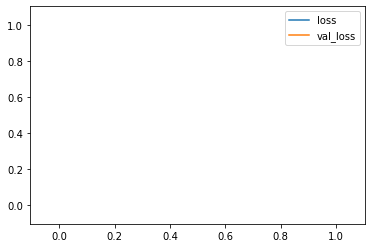

In [173]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

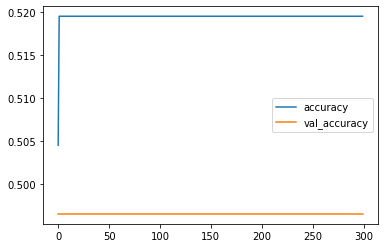

In [139]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

(157, 1)


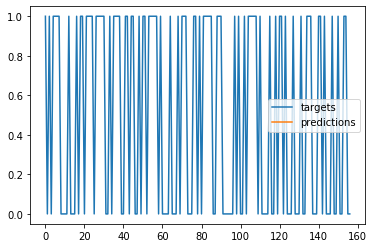

In [161]:
# One-step forecast using true targets
outputs = model.predict(X_test)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y_test, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()